## Importing Dependencies and Initializing Parameters

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2025-05-24 16:18:12.373497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748103492.603432      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748103492.673780      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/Real_Life_Violence_Dataset'
CLASS_LIST = ['Violence','NonViolence']
seed = 42
img_height, img_width = 100, 100
batch_size = 8
SEQUENCE_LENGTH = 16

## Preprocessing

In [3]:
def extract_frames(video_path):

    frames = []
    video_reader = cv2.VideoCapture(video_path)
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames//SEQUENCE_LENGTH,1)

    for i in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)

        ret,frame = video_reader.read()
        if not ret:
            break

        resized_frame = cv2.resize(frame,(img_height,img_width))

        normalized_frame = resized_frame / 255.0

        frames.append(normalized_frame)

    video_reader.release()

    return frames

def create_dataset(max_vid_per_class = 750):

    features = []
    labels = []


    for class_index,class_name in enumerate(CLASS_LIST):

        print(f"Extracting Data of Class:{class_name}")

        files_list = os.listdir(os.path.join(data_dir,class_name))

        count = 0
        for filename in files_list:
            if count >= max_vid_per_class:
                break

            video_path = os.path.join(data_dir,class_name,filename)
            frames = extract_frames(video_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                count += 1

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

In [4]:
features,labels = create_dataset()

Extracting Data of Class:Violence
Extracting Data of Class:NonViolence


[h264 @ 0x150601800] mb_type 104 in P slice too large at 98 31
[h264 @ 0x150601800] error while decoding MB 98 31
[h264 @ 0x150601800] mb_type 104 in P slice too large at 98 31
[h264 @ 0x150601800] error while decoding MB 98 31
[h264 @ 0x150601800] mb_type 104 in P slice too large at 98 31
[h264 @ 0x150601800] error while decoding MB 98 31
[h264 @ 0x150601800] mb_type 104 in P slice too large at 98 31
[h264 @ 0x150601800] error while decoding MB 98 31


In [5]:
features_temp,features_test,labels_temp,labels_test = train_test_split(features,labels,
                                                                        test_size=0.1,
                                                                        random_state=seed)

In [6]:
features_train,features_val,labels_train,labels_val = train_test_split(features_temp,labels_temp,
                                                                        test_size=0.2,
                                                                        random_state=seed)

In [7]:
ohc_labels_train = to_categorical(labels_train)
ohc_labels_val = to_categorical(labels_val)
ohc_labels_test = to_categorical(labels_test)

## Model Building and Training

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Input(shape=(16, 100, 100, 3)))

model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())  
model.add(Dropout(0.4))  

model.add(Dense(units=256, activation='relu'))  
model.add(BatchNormalization())  
model.add(Dropout(0.4))  

model.add(Dense(units=2, activation='softmax'))  

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


I0000 00:00:1748104385.881092      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748104385.881851      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 16, 100, 100, 64)    │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 100, 100, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 8, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 8, 50, 50, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 50, 50, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 4, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 4, 25, 25, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 25, 25, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 12, 12, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 2, 12, 12, 512)      │       3,539,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 12, 12, 512)      │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 6, 6, 512)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,227,458 (54.27 MB)

 Trainable params: 14,224,002 (54.26 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [9]:
# Reduce learning rate when validation accuracy plateaus
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

checkpoint1 = ModelCheckpoint(
    filepath='best3dcnn_model.weights.h5',   
    monitor='val_accuracy',     
    save_best_only=True,        
    save_weights_only=True,
    mode='max',                 
    verbose=1                   
)

checkpoint2 = ModelCheckpoint(
    filepath='best3dcnn_model.keras',   
    monitor='val_accuracy',     
    save_best_only=True,        
    save_weights_only=False,
    mode='max',                 
    verbose=1                   
)


early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=15,             
    restore_best_weights=True,  
    mode='min'              
)

In [11]:
history = model.fit(features_train, ohc_labels_train, 
                    epochs=50, batch_size=8, 
                    validation_data=(features_val, ohc_labels_val), 
                    callbacks=[early_stopping, checkpoint1, checkpoint2, reduce_lr])

Epoch 1/50


I0000 00:00:1748104402.279750    6100 service.cc:148] XLA service 0x7d3884007410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748104402.280446    6100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748104402.280467    6100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748104402.987144    6100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748104412.879377    6100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5471 - loss: 1.0625
Epoch 1: val_accuracy improved from -inf to 0.47037, saving model to best3dcnn_model.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.47037, saving model to best3dcnn_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 48s 228ms/step - accuracy: 0.5474 - loss: 1.0615 - val_accuracy: 0.4704 - val_loss: 2.3915 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6191 - loss: 0.7856
Epoch 2: val_accuracy improved from 0.47037 to 0.47778, saving model to best3dcnn_model.weights.h5

Epoch 2: val_accuracy improved from 0.47037 to 0.47778, saving model to best3dcnn_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 27s 196ms/step - accuracy: 0.6192 - loss: 0.7854 - val_accuracy: 0.4778 - val_loss: 2.0354 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7020 - loss: 0.6634
Epoch 3: val_accuracy improved from 0.47778 to 0.61852, saving model to best3

In [12]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

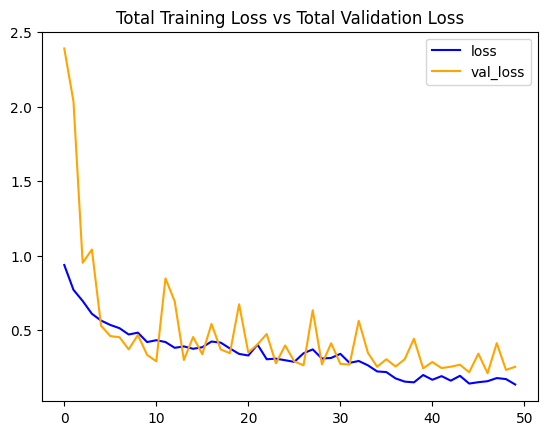

In [13]:
plot_metric(history, 'loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

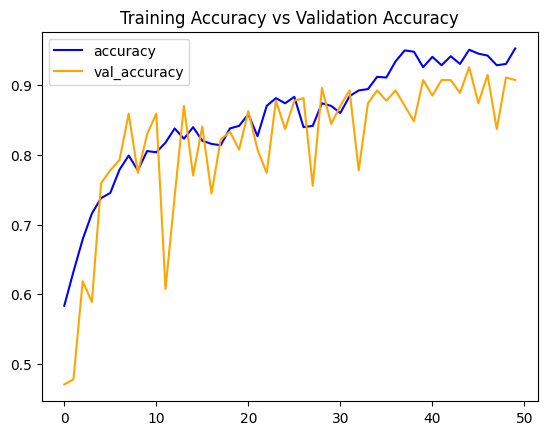

In [14]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy')

## Testing

In [15]:
import time

In [16]:
start_time = time.perf_counter()
loss, accuracy = model.evaluate(features_test, ohc_labels_test)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8690 - loss: 0.3920  
Elapsed time: 9.318049 seconds
Test Loss: 0.28332290053367615
Test Accuracy: 0.8999999761581421


In [17]:
labels_predict = model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(ohc_labels_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step


In [18]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9


### Confusion Matrix Representation

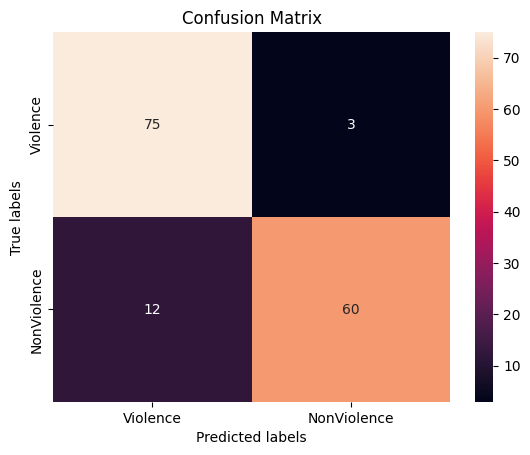

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Violence', 'NonViolence'])
ax.yaxis.set_ticklabels(['Violence', 'NonViolence'])

plt.savefig('/kaggle/working/confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

plt.show()